# **Instagram Likes Predictor**
*By Khan Naseer Ahmed, Koppar Devansh Sunil & Garodia Shivanshi*

*The github repository and the scraped data for this project can be found [here](https://github.com/naseer2426/Data-Analysis-Project)*

---

## **Introduction**

This is a data science project that is prepared in fulfilment of the module requirements (CE9010 - Introduction to Data Science). This notebook will discuss the following:



*   The Data - Problem, Acquisition and Exploration
*   Pre-Processing and Data Analysis

## **Objective & The Data Problem**

Have you ever wanted to know how many likes your instagram post will get, before even posting it? Is it possible to predict the number of likes on Instagam? This question was the motivation behind our data analysis project.

In this notebook, we create a regression model that predicts instagram likes from scratch.

## **Data Acquisition**
### - Khan Naseer Ahmed (U1722257F)

The data was collected using a Selenium web scrapper that scrapped instagram.com. All the code used for scrapping is  [here](https://github.com/naseer2426/Data-Analysis-Project).  This web scrapper collected data on top 20 posts on my instagram feed. This data included, likes, comments, people tagged, caption, sentiment analysis of the caption, number of followers/following of the user.

Sentiment analysis was done using the paralleldots API.

The web scrapper was run as a sub-process in a javascript code that was also running a discord bot. This javascript code ran the web scrapper subprocess as a cron job every 6 minutes for around 3 days. 

```javascript
var scrape = () => {
    const channel = client.channels.cache.get("701711183824289806");
    console.log("started scrapping");
    channel.send("Scrapping session finsished");
    var stdout = child.execSync("python3 scrapper.py").toString();
    channel.send(stdout);
};

var job = new CronJob("0 0,6,12,18,24,30,36,42,48,54 * * * *", function () {
    scrape();
});
job.start();
```

The discord bot was set up so that to track the process of the scrapper. It could tell how many posts had been scrapped. It would also send error messages if the web scrapper failed for any reason.


##### **Problems faced while scrapping**

Since instagram is an infinte scroll type of website, the web page doesn't load in all the posts at once. Depending on the size of the post, it loads in 5-8 posts. Once you start scrolling, it unloads the old posts and loads the new posts. 

This was the most difficult problem to solve. There was a need to uniquely identify a post, since its position on the HTML kept changing depeinding on how many posts before it have been unloaded, and how many posts after it have been loaded. 

Initially the post was uniquely identified with the src tag of the image/video in the post. This logic eventually failed becuase instagram sources the images from different databases depending traffic. This meant the src link of the same post changed depending on traffic.

The src url had to be parsed to find the unique identifier of an image irrespective of the database its being sourced from.

```python
def url_cleaner(url):
    if url == None:
        return None
    target_index = url.find("?")
    start_index = target_index
    if start_index == -1:
        return None
    for i in range(start_index, -1, -1):
        if url[i] == "/":
            break
    start_index = i
    return url[start_index+1:target_index]
```

After finding the unique identifier for a post, the logic of scrapping the data and scrolling distance had to be developed.


Posts that haven't changed any data (liks,comments etc) had to be excluded from the csv file to avoid duplicates. The logic that handled all this is given below.

```python
while post_count < REQUIRED_POSTS:
        
        curr_post = {"username": None, "likes": None, "comments": None, "tags": None,
                     "time_posted": None, "caption": None, "curr_time": None, "is_video": None, "post_link": None}
        curr_unique_post = {"post_id": None,
                            "username": None, "post_link": None}

        
        post_xpath = "/html/body/div[1]/section/main/section/div[1]/div[1]/div/article["+str(
            i)+"]"

        user_details_xpath = post_xpath+"/div[2]/div[1]/div[1]/div/a"
        post_user_details = wait_for_element(
            "xpath", user_details_xpath, 5, driver)
        post_caption_xpath = post_xpath+"/div[2]/div[1]/div[1]/div/span"
        post_caption_details = wait_for_element(
            "xpath", post_caption_xpath, 5, driver)
        more = post_caption_details.find_elements_by_xpath(".//span")
        likes_div_xpath = post_xpath+"/div[2]/section[2]/div"
        comments_div_xpath = post_xpath+"/div[2]/div[1]/div[2]/div[1]/a"
        posted_time_div = post_xpath+"/div[2]/div[2]/a/time"

        video_src = None
        image_src = None
        is_video = False
        image_tags = []
        try:
            video_src = wait_for_element(
                "xpath", post_xpath+"/div[1]/div", 5, driver).find_element_by_tag_name("video").get_attribute("src")
        except:
            pass

        if (video_src):
            is_video = True

        if not is_video:
            image_node = wait_for_element(
                "xpath", post_xpath+"/div[1]/div", 5, driver).find_element_by_tag_name("img")
            image_src = image_node.get_attribute("src")
            image_tags = image_node.get_attribute("alt")

            image_tags = extract_tags(image_tags)

        if url_cleaner(video_src) in post_data or url_cleaner(image_src) in post_data:

            loaded_posts = wait_for_element(
                "xpath", "/html/body/div[1]/section/main/section/div[1]/div[1]/div", 5, driver).find_elements_by_tag_name("article")

            num_loaded = len(loaded_posts)

            if i < num_loaded:
                i += 1
            elif i > num_loaded:
                i = num_loaded
            else:
                driver.execute_script("window.scrollBy(0, 900);")
                time.sleep(2)

            continue

        likes_span = wait_for_element(
            "xpath", likes_div_xpath, 5, driver).find_elements_by_tag_name("span")[-1]
        try:
            comments_span = wait_for_element(
                "xpath", comments_div_xpath, 2, driver).find_element_by_tag_name("span")
        except:
            comments_span = None
        posted_time = wait_for_element(
            "xpath", posted_time_div, 5, driver).get_attribute("datetime")
        
        if len(more) > 1:
            
            more[1].find_element_by_tag_name("button").click()
            if post_count >= initial_loaded_posts:

                change = 0
                checker_src = ''
                while (url_cleaner(checker_src) != url_cleaner(image_src) and url_cleaner(checker_src) != url_cleaner(video_src)):
                    checker_xpath = "/html/body/div[1]/section/main/section/div[1]/div[1]/div/article["+str(
                        i-change)+"]/div[1]/div"
                    checker_node = wait_for_element(
                        "xpath", checker_xpath, 5, driver)
                    try:
                        checker_src = checker_node.find_element_by_tag_name(
                            "video").get_attribute("src")
                        if checker_src != video_src:
                            change += 1
                    except:
                        checker_src = checker_node.find_element_by_tag_name(
                            "img").get_attribute("src")
                        if checker_src != image_src:
                            change += 1
                
                post_caption_xpath = "/html/body/div[1]/section/main/section/div[1]/div[1]/div/article["+str(
                    i-change)+"]/div[2]/div[1]/div[1]/div/span"
            post_caption_details = wait_for_element(
                "xpath", post_caption_xpath, 5, driver)
            if post_count > initial_loaded_posts:
                i -= 1
        post_caption = post_caption_details.get_attribute("innerText")
        post_user_profile = post_user_details.get_attribute("href")
        post_user_name = post_user_details.get_attribute("innerText")
        likes = likes_span.get_attribute("innerText")
        if comments_span:
            comments = comments_span.get_attribute("innerText")
        else:
            comments = '0'

        datetime_extraction_script = 'return new Date("' + \
            posted_time+'").toString()'
        
        posted_time = driver.execute_script(datetime_extraction_script)
       

        curr_post["username"] = post_user_name
        curr_post["likes"] = likes
        curr_post["comments"] = comments
        curr_post["tags"] = str(image_tags)
        curr_post["time_posted"] = posted_time
        curr_post["caption"] = post_caption
        curr_post["curr_time"] = driver.execute_script(
            "return new Date().toString()")
        curr_post["is_video"] = is_video
        if is_video:
            curr_post["post_link"] = video_src
            curr_unique_post["post_link"] = video_src
            
        else:
            curr_post["post_link"] = image_src
            curr_unique_post["post_link"] = image_src
            

        
        curr_unique_post["username"] = post_user_name
        post_data[url_cleaner(curr_post["post_link"])] = True
        
        if no_duplicate(curr_post, historical_data):
            write_to_csv([curr_post], "test.csv")

        
        if url_cleaner(curr_post["post_link"]) not in historical_data:
            curr_unique_post["post_id"] = get_unique_id()
            write_to_csv([curr_unique_post], "unique_posts.csv")
        post_count += 1
        
        driver.execute_script("window.scrollBy(0, 900);")
        time.sleep(2)
```



## **Data Preprocessing**
### - Garodia Shivanshi (U1811801H)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


**Libraries**

The libraries used are pandas, numpy, matplotlib, seaborn, scipy, datetime. 

This list is not exhaustive, and there will be more that are uploaded at a later point in the notebook.



In [2]:
# Import libraries

# math library
import numpy as np
import pandas as pd

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#datetime library
from datetime import datetime





The first one is main_data which consists of information about posts. Each unique post has its own unique post.
We used three extracted datasets for our project.



In [3]:
main_data = pd.read_csv("Data/post_data.csv")
main_data.head()

,username,likes,comments,tags,time_posted,caption,curr_time,is_video,post_link,post_id
0,anushadatta,2,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 14:49:20 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1
1,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 14:49:24 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2
2,anveshaa_,293,6,['sxnskritiii'],Mon Apr 20 2020 04:04:00 GMT+0800 (Singapore S...,Happy happy birthday mini chipmunk 😘💋 it’s bee...,Mon Apr 20 2020 14:49:27 GMT+0800 (Singapore S...,False,https://instagram.fsin9-2.fna.fbcdn.net/v/t51....,3
3,sam.ag_265,118,9,"['vithaljalan,', 'akshitgupta__']",Mon Apr 20 2020 00:23:56 GMT+0800 (Singapore S...,BLOOPER~1\nor a CANDID 🤔🤔 ❤ .\n#THROWBACK,Mon Apr 20 2020 14:49:29 GMT+0800 (Singapore S...,False,https://instagram.fsin9-2.fna.fbcdn.net/v/t51....,4
4,tharakan.captures,233,14,"['jj_architecture,', 'geometrygrammer,', 'srs_...",Sun Apr 19 2020 21:03:22 GMT+0800 (Singapore S...,Miss walking around Singapore trying to find i...,Mon Apr 20 2020 14:49:31 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,5


In [4]:
print("number of data points are: ",main_data.shape[0])

number of data points are:  1215


The second dataset is for user data and consists of data regarding the user's profile.


In [5]:
user_data = pd.read_csv("Data/user_data.csv")
user_data.head()

,username,posts,followers,following
0,shxkir.ibrxhim,24,281,312
1,_codehub_,"1,605",156k,81
2,nazri.in,0,53,64
3,lzc_97,27,173,483
4,ahhhhying,7,302,306


The third dataset analyzes the captions of the post using senntiment analysis. 

*'0' means the post is mostly neutral.*

*'-1' means the post is has negative sentiments.*

*'1' means the post has  positive sentiments.*





In [6]:
sentiment_data = pd.read_csv("Data/caption_sentiment_anlaysis_corrected.csv")
sentiment_data.head()

,post_id,caption,sentiment_analysis
0,1,young & alive - bazzi,0
1,2,Happy happy birthday mini chipmunk 😘💋 it’s bee...,1
2,3,BLOOPER~1 ... more,0
3,4,BLOOPER~1\nor a CANDID 🤔🤔 ❤ .\n#THROWBACK,0
4,5,Just putting this here.... #nohomo .... more,1


I created a new dataset - **latest_data** -  to combine all the relevant information from the three datasets. I added the user data and sentiment data to the main data file. 

The resultant unedited dataset consists of 17 features and 1214 data points.

In [7]:
latest_data = main_data
latest_data = pd.merge(latest_data, user_data, on='username')
latest_data = pd.merge(latest_data, sentiment_data, on='post_id')
latest_data = latest_data.drop(columns=['caption_y'])
latest_data = latest_data.rename(columns={"caption_x": "caption"})
latest_data.head()

,username,likes,comments,tags,time_posted,caption,curr_time,is_video,post_link,post_id,posts,followers,following,sentiment_analysis
0,anushadatta,2,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 14:49:20 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
1,anushadatta,138,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 21:41:11 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
2,anushadatta,148,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Tue Apr 21 2020 10:18:45 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
3,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 14:49:24 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2,203,958,"1,398",1
4,shawartma,75,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 21:41:16 GMT+0800 (Singapore S...,False,https://instagram.fsin8-1.fna.fbcdn.net/v/t51....,2,203,958,"1,398",1


In [8]:
latest_data.shape

(1214, 14)

Most of the data, is in its raw form and shows the 'object' datatype. Hence, the data needs to be converted into other datatypes.

In [9]:
latest_data.info()
print('_'*40)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1213
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   username            1214 non-null   object
 1   likes               1214 non-null   object
 2   comments            1214 non-null   object
 3   tags                1214 non-null   object
 4   time_posted         1214 non-null   object
 5   caption             1214 non-null   object
 6   curr_time           1214 non-null   object
 7   is_video            1214 non-null   bool  
 8   post_link           1214 non-null   object
 9   post_id             1214 non-null   int64 
 10  posts               1214 non-null   object
 11  followers           1214 non-null   object
 12  following           1214 non-null   object
 13  sentiment_analysis  1214 non-null   int64 
dtypes: bool(1), int64(2), object(11)
memory usage: 134.0+ KB
________________________________________


There are no missing or null values in our dataset.

In [10]:
latest_data.isnull().values.any()

False

We convert all the object columns with a series of letters to the string datatype. 

To make it easier to convert numerical columns to integer or float datatypes, we removed commas from the numbers.

In [11]:
latest_data['username'] = latest_data['username'].astype(str)
latest_data['tags'] = latest_data['tags'].astype(str)
latest_data['time_posted'] = latest_data['time_posted'].astype(str)
latest_data['caption'] = latest_data['caption'].astype(str)
latest_data['curr_time'] = latest_data['curr_time'].astype(str)
latest_data['post_link'] = latest_data['post_link'].astype(str)
latest_data['likes'][901]='1'

/Library/Python/3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


One data point has ann error and had to be corrected manually.

In [12]:
latest_data['likes'] = latest_data['likes'].str.replace(',', '')
latest_data['comments'] = latest_data['comments'].str.replace(',', '')
latest_data['posts'] = latest_data['posts'].str.replace(',', '')
latest_data['followers'] = latest_data['followers'].str.replace(',', '')
latest_data['following'] = latest_data['following'].str.replace(',', '')

In [13]:
latest_data['likes'] = latest_data['likes'].astype(int)
latest_data['comments'] = latest_data['comments'].astype(int)
latest_data['posts'] = latest_data['posts'].astype(int)

The 'followers' and 'following' column formats needed to be processed further to take into consideration some numbers expressed as 'k' and 'm'.

In [14]:
follow = pd.Series([])

for j in ['followers','following']:
    for i in range(len(latest_data)):
        if 'm' in latest_data[j][i]:
            if '.' in latest_data[j][i] :
                latest_data[j] = latest_data[j].str.replace('m', '00000')
                latest_data[j] = latest_data[j].str.replace('.', '')

            else:
                latest_data[j] = latest_data[j].str.replace('m', '000000')
        elif 'k' in latest_data[j][i]:
            if '.' in latest_data[j][i] :
                latest_data[j] = latest_data[j].str.replace('k', '00')
                latest_data[j] = latest_data[j].str.replace('.', '')

            else:
                latest_data[j] = latest_data[j].str.replace('k', '000')
                
                
latest_data['followers'] = latest_data['followers'].astype(int)
latest_data['following'] = latest_data['following'].astype(int)
latest_data.head()

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,username,likes,comments,tags,time_posted,caption,curr_time,is_video,post_link,post_id,posts,followers,following,sentiment_analysis
0,anushadatta,2,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 14:49:20 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
1,anushadatta,138,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 21:41:11 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
2,anushadatta,148,0,[],Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Tue Apr 21 2020 10:18:45 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
3,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 14:49:24 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1
4,shawartma,75,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 21:41:16 GMT+0800 (Singapore S...,False,https://instagram.fsin8-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1


The column 'tags' needs to be converted to a numerical form. Hence, we created a new column which counts the number of tags in each post.

In [15]:
latest_data['tags'] = list(latest_data['tags'])
num_tags = pd.Series([])

for i in range(len(latest_data)):
    num_comma = latest_data['tags'][i].count(',')
    if num_comma == 0:
        if len(latest_data['tags'][i])==2:
            num_tags[i]=0
        else:
            num_tags[i]=1
    else:
        num_tags[i] = num_comma/2 + 1
    
latest_data.insert(4, 'num_tags', num_tags)
latest_data.head()

/Library/Python/3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,username,likes,comments,tags,num_tags,time_posted,caption,curr_time,is_video,post_link,post_id,posts,followers,following,sentiment_analysis
0,anushadatta,2,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 14:49:20 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
1,anushadatta,138,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Mon Apr 20 2020 21:41:11 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
2,anushadatta,148,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,Tue Apr 21 2020 10:18:45 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
3,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 14:49:24 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1
4,shawartma,75,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,Mon Apr 20 2020 21:41:16 GMT+0800 (Singapore S...,False,https://instagram.fsin8-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1


We processed the caption further to check if caption length has an effect on the number of likes generated by a post.

In [16]:
caption_len = pd.Series([])

for i in range(len(latest_data)):
    caption_len[i]=len(latest_data['caption'][i])
    
latest_data.insert(7, 'caption_len', caption_len)
latest_data.head()

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,username,likes,comments,tags,num_tags,time_posted,caption,caption_len,curr_time,is_video,post_link,post_id,posts,followers,following,sentiment_analysis
0,anushadatta,2,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,21,Mon Apr 20 2020 14:49:20 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
1,anushadatta,138,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,21,Mon Apr 20 2020 21:41:11 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
2,anushadatta,148,0,[],0.0,Mon Apr 20 2020 14:47:48 GMT+0800 (Singapore S...,young & alive - bazzi,21,Tue Apr 21 2020 10:18:45 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
3,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,700,Mon Apr 20 2020 14:49:24 GMT+0800 (Singapore S...,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1
4,shawartma,75,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,Mon Apr 20 2020 14:44:42 GMT+0800 (Singapore S...,M O O D 🌈\nI spent days thinking of whom to dr...,700,Mon Apr 20 2020 21:41:16 GMT+0800 (Singapore S...,False,https://instagram.fsin8-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1


Next, we needed to process the time columns and convert them to the datetime format. 

In [17]:
for i in ['time_posted','curr_time']:
  latest_data[i] = latest_data[i].str.replace('GMT', '')
  latest_data[i] = latest_data[i].str.replace('(Singapore Standard Time)', '')
  latest_data[i] = latest_data[i].str.replace('+', '')
  latest_data[i] = latest_data[i].str.replace('0800', '')
  latest_data[i] = latest_data[i].str.replace('  ', '')
  latest_data[i] =  pd.to_datetime(latest_data[i], format='%a %b %d %Y %H:%M:%S()')


In [18]:
latest_data['curr_time'].head()

0   2020-04-20 14:49:20
1   2020-04-20 21:41:11
2   2020-04-21 10:18:45
3   2020-04-20 14:49:24
4   2020-04-20 21:41:16
Name: curr_time, dtype: datetime64[ns]

Next we add a column to calculate the time passed between when the post was posted and when the data for 'likes' was collected. This time is converted to number of seconds to standardise the format.

In [19]:
time_passed = pd.Series([])

for i in range(len(latest_data)):
  time_passed[i] = (latest_data['curr_time'][i]-latest_data['time_posted'][i]).total_seconds()
    
latest_data.insert(9, 'time_passed', time_passed)
latest_data['time_passed'].head()

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


0       92.0
1    24803.0
2    70257.0
3      282.0
4    24994.0
Name: time_passed, dtype: float64

Finally, all the data has been converted to the required format.

In [20]:
latest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1213
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   username            1214 non-null   object        
 1   likes               1214 non-null   int64         
 2   comments            1214 non-null   int64         
 3   tags                1214 non-null   object        
 4   num_tags            1214 non-null   float64       
 5   time_posted         1214 non-null   datetime64[ns]
 6   caption             1214 non-null   object        
 7   caption_len         1214 non-null   int64         
 8   curr_time           1214 non-null   datetime64[ns]
 9   time_passed         1214 non-null   float64       
 10  is_video            1214 non-null   bool          
 11  post_link           1214 non-null   object        
 12  post_id             1214 non-null   int64         
 13  posts               1214 non-null   int64       

#### **Data Visualization**


In [21]:
latest_data.head()

,username,likes,comments,tags,num_tags,time_posted,caption,caption_len,curr_time,time_passed,is_video,post_link,post_id,posts,followers,following,sentiment_analysis
0,anushadatta,2,0,[],0.0,2020-04-20 14:47:48,young & alive - bazzi,21,2020-04-20 14:49:20,92.0,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
1,anushadatta,138,0,[],0.0,2020-04-20 14:47:48,young & alive - bazzi,21,2020-04-20 21:41:11,24803.0,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
2,anushadatta,148,0,[],0.0,2020-04-20 14:47:48,young & alive - bazzi,21,2020-04-21 10:18:45,70257.0,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,1,215,783,450,0
3,shawartma,4,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,2020-04-20 14:44:42,M O O D 🌈\nI spent days thinking of whom to dr...,700,2020-04-20 14:49:24,282.0,False,https://instagram.fsin9-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1
4,shawartma,75,0,"['sharpie,', 'calligraphymasters,', 'drawingin...",5.0,2020-04-20 14:44:42,M O O D 🌈\nI spent days thinking of whom to dr...,700,2020-04-20 21:41:16,24994.0,False,https://instagram.fsin8-1.fna.fbcdn.net/v/t51....,2,203,958,1398,1


We create a new dataset with only the relevant numerical columns available.

In [22]:
latest_data_num = latest_data.drop(['username','tags','caption','post_link','time_posted','curr_time','post_id'], axis = 1)

In [23]:
latest_data_num.head()

,likes,comments,num_tags,caption_len,time_passed,is_video,posts,followers,following,sentiment_analysis
0,2,0,0.0,21,92.0,False,215,783,450,0
1,138,0,0.0,21,24803.0,False,215,783,450,0
2,148,0,0.0,21,70257.0,False,215,783,450,0
3,4,0,5.0,700,282.0,False,203,958,1398,1
4,75,0,5.0,700,24994.0,False,203,958,1398,1


###Observation of target variable¶


((array([-3.25308413, -2.99206247, -2.84666759, ...,  2.84666759,
          2.99206247,  3.25308413]),
  array([      1,       2,       2, ..., 1462468, 1625188, 1732193])),
 (102479.34848578747, 84321.96787479409, 0.7783535401042077))

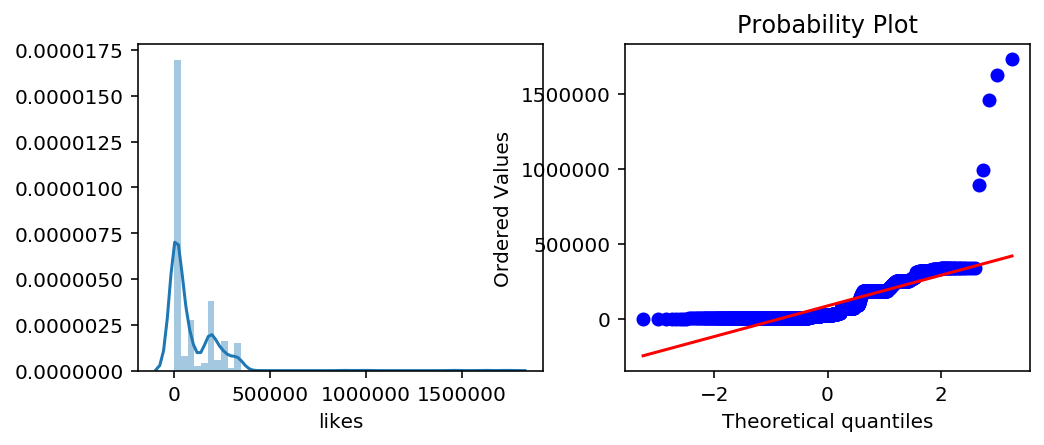

In [24]:
plt.figure(figsize = (8,3))
plt.subplot(121)
sns.distplot(latest_data['likes'])
plt.subplot(122)
stats.probplot(latest_data['likes'],plot=plt)

Likes are not normally distributed. The target is rightly skewed. Hence we will need to normalise data while using machine learning techniques.

###Observation of independent variables

The scatterplot shows that lkes are correlated with comments, Time passed, posts, followers and sentiment analysis. 

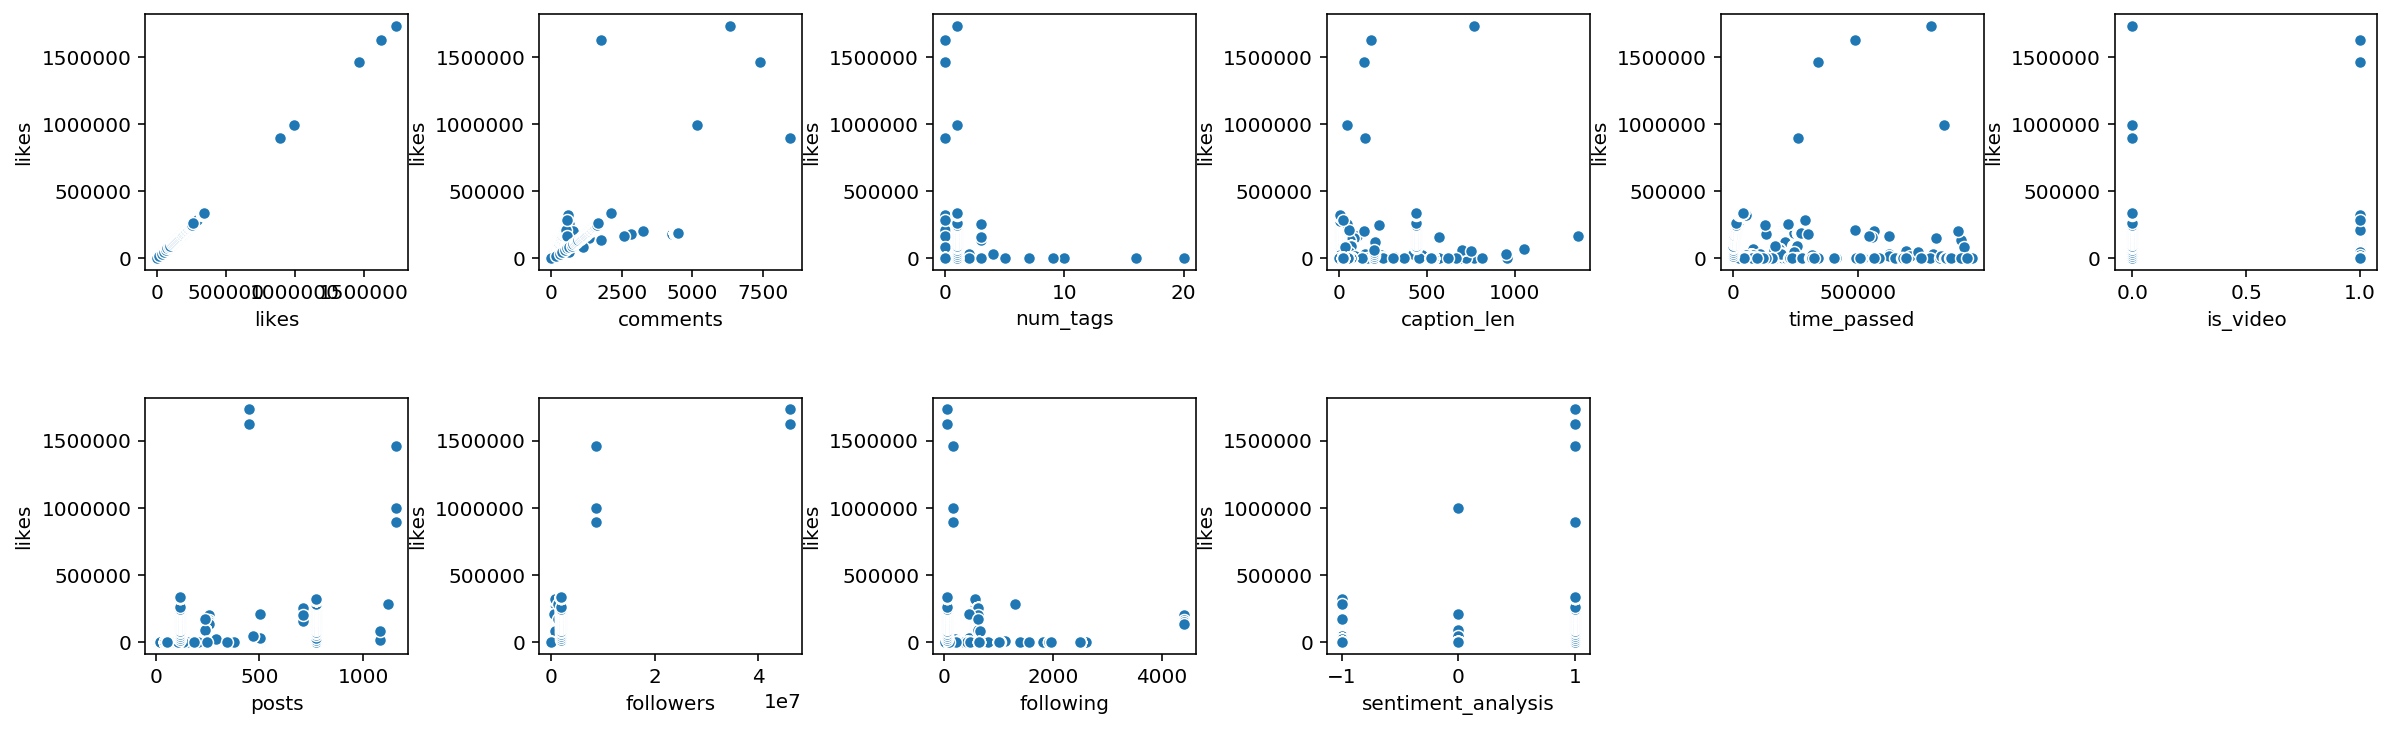

In [25]:
plt.figure(figsize = (20,20))
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
for i,col in enumerate(latest_data_num.columns):
    plt.subplot(6,6,i+1)
    sns.scatterplot(x=col, y="likes", data=latest_data_num)

The next graph plots 'likes' vs 'time_passed' for the posts with the largest number of data points. It is evident that 'likes' increase with time.

          username  likes  comments tags  num_tags         time_posted  \
488  mydarlingmyla   2538        17   []       0.0 2020-04-21 08:30:48   

                                               caption  caption_len  \
488  Dog piling the dog😄Today is our Wyatt’s 6th bi...          240   

              curr_time  time_passed  is_video  \
488 2020-04-21 09:19:56       2948.0     False   

                                             post_link  post_id  posts  \
488  https://instagram.fsin9-1.fna.fbcdn.net/v/t51....      104    502   

     followers  following  sentiment_analysis  
488     563000        457                   1  


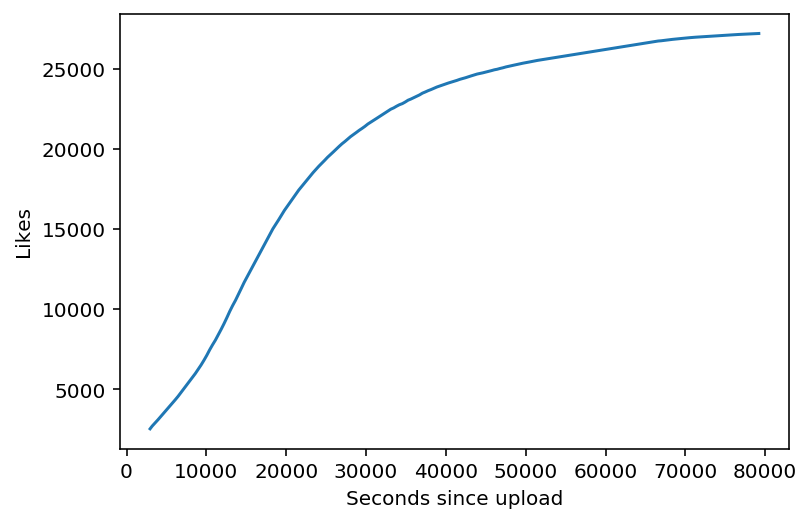

        username   likes  comments               tags  num_tags  \
36  alecbenjamin  180232      4272  ['alexbstoddard']       1.0   

           time_posted          caption  caption_len           curr_time  \
36 2020-04-19 02:39:37  i look like a 🍌           15 2020-04-20 14:49:40   

    time_passed  is_video                                          post_link  \
36     130203.0     False  https://instagram.fsin9-2.fna.fbcdn.net/v/t51....   

    post_id  posts  followers  following  sentiment_analysis  
36        8    258    1400000       4403                  -1  


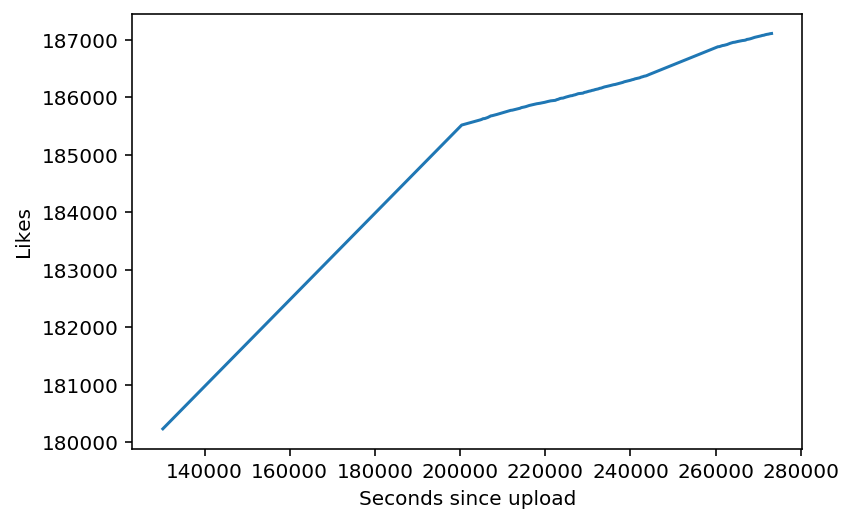

       username  likes  comments tags  num_tags         time_posted caption  \
308  kennethseb    814        23   []       0.0 2020-04-21 15:39:49   Fail.   

     caption_len           curr_time  time_passed  is_video  \
308            5 2020-04-21 15:42:17        148.0      True   

                                             post_link  post_id  posts  \
308  https://instagram.fsin9-1.fna.fbcdn.net/v/t50....      112    770   

     followers  following  sentiment_analysis  
308     790000        572                  -1  


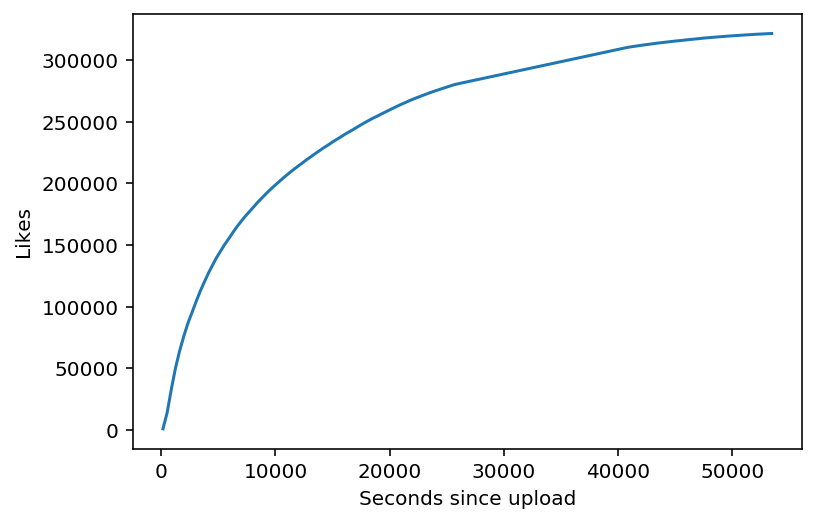

      username  likes  comments tags  num_tags         time_posted  \
783  kanangill   1039        14   []       0.0 2020-04-21 15:43:50   

                                               caption  caption_len  \
783  It’s around the corner. My special. 24th! I me...          213   

              curr_time  time_passed  is_video  \
783 2020-04-21 15:48:19        269.0     False   

                                             post_link  post_id  posts  \
783  https://instagram.fsin9-1.fna.fbcdn.net/v/t51....      113    291   

     followers  following  sentiment_analysis  
783     347000        198                  -1  


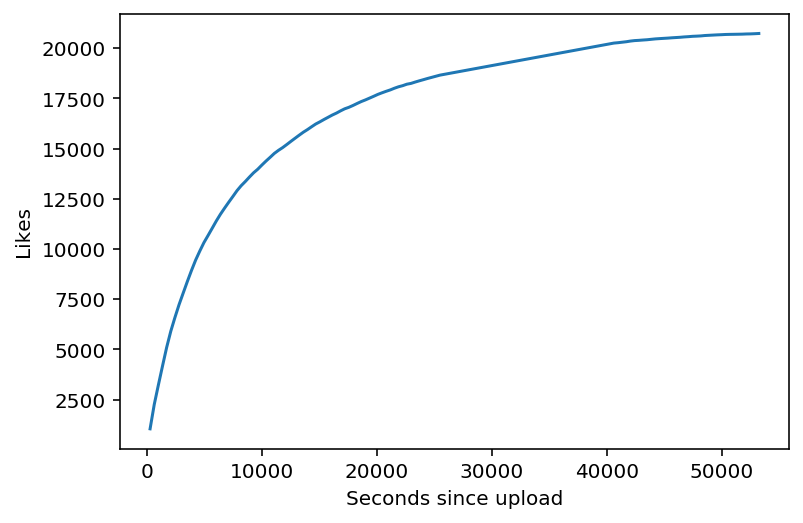

       username  likes  comments tags  num_tags         time_posted  \
203  kennethseb  67559       209   []       0.0 2020-04-19 16:34:23   

                                               caption  caption_len  \
203  Ken and Chip #84.\n\n_________________________...         1055   

              curr_time  time_passed  is_video  \
203 2020-04-20 14:49:45      80122.0     False   

                                             post_link  post_id  posts  \
203  https://instagram.fsin9-1.fna.fbcdn.net/v/t51....       10    770   

     followers  following  sentiment_analysis  
203     790000        572                   1  


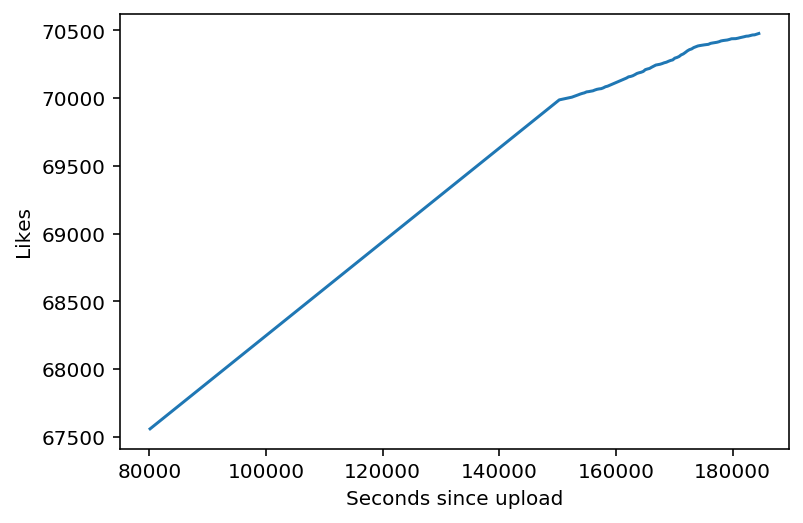

In [26]:
latest_data_copy = latest_data.copy()
single_posts = []

for i in range(1,118):
  single_post_data = latest_data_copy.loc[latest_data_copy["post_id"]==i]
  single_posts.append(single_post_data)

single_posts.sort(reverse = True,key = lambda x: len(x))

for i in range(5):
  single_post_data = single_posts[i]
  print(single_post_data.head(1))
  y_axis = single_post_data["likes"]
  x_axis = single_post_data["time_passed"]

  plt.plot(x_axis,y_axis)
  plt.ylabel("Likes")
  plt.xlabel("Seconds since upload")
  plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

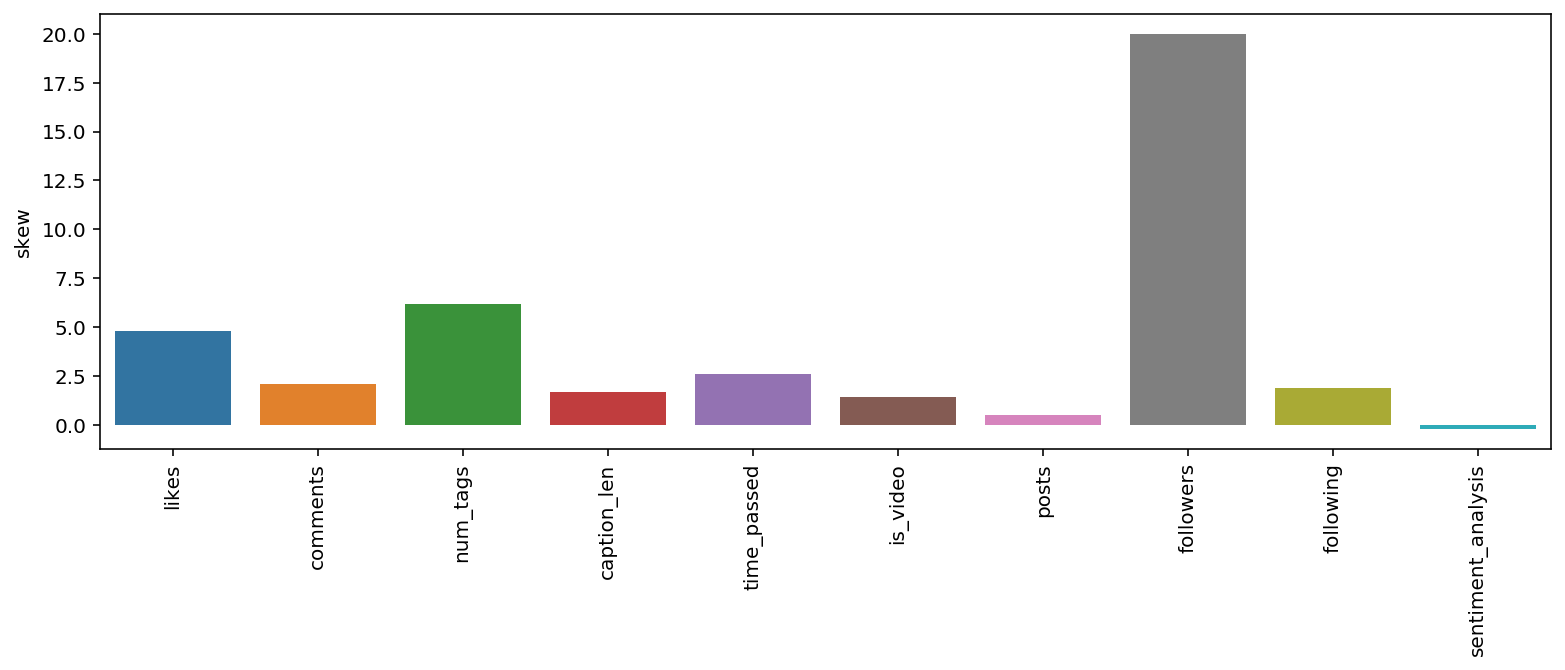

In [27]:
skew_list = []
for col in latest_data_num.columns:
    median = latest_data_num[col].median()
    skew = stats.skew(latest_data_num[col].fillna(median))
    skew_list.append(skew)
skew_table = pd.DataFrame(skew_list, index = latest_data_num.columns, columns=["skew"])

plt.figure(figsize=(13,4))
sns.barplot(skew_table.index, skew_table["skew"])
plt.xticks(rotation=90)

##Correlation Analysis

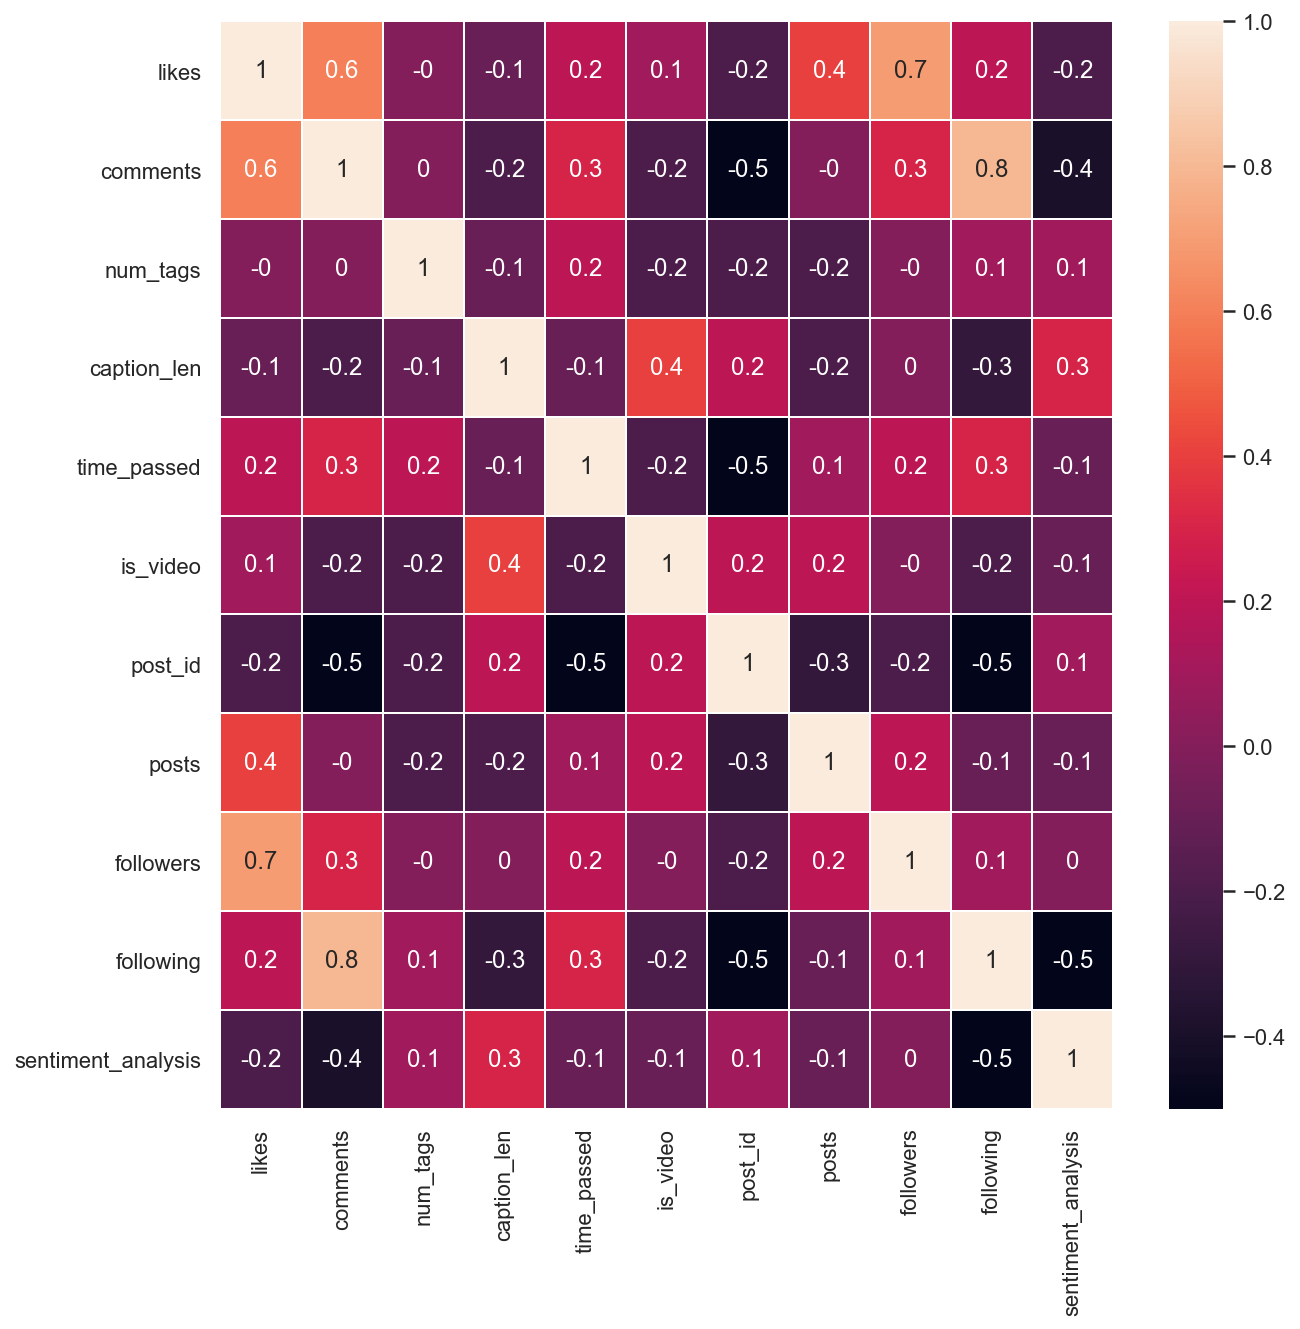

In [28]:
plt.figure(figsize = (10,10))
sns.set(rc={'figure.figsize':(10,10)})

cor = latest_data.corr().round(1)

type(cor)
sns.heatmap(data=cor, annot=True, linewidths = 0.5)

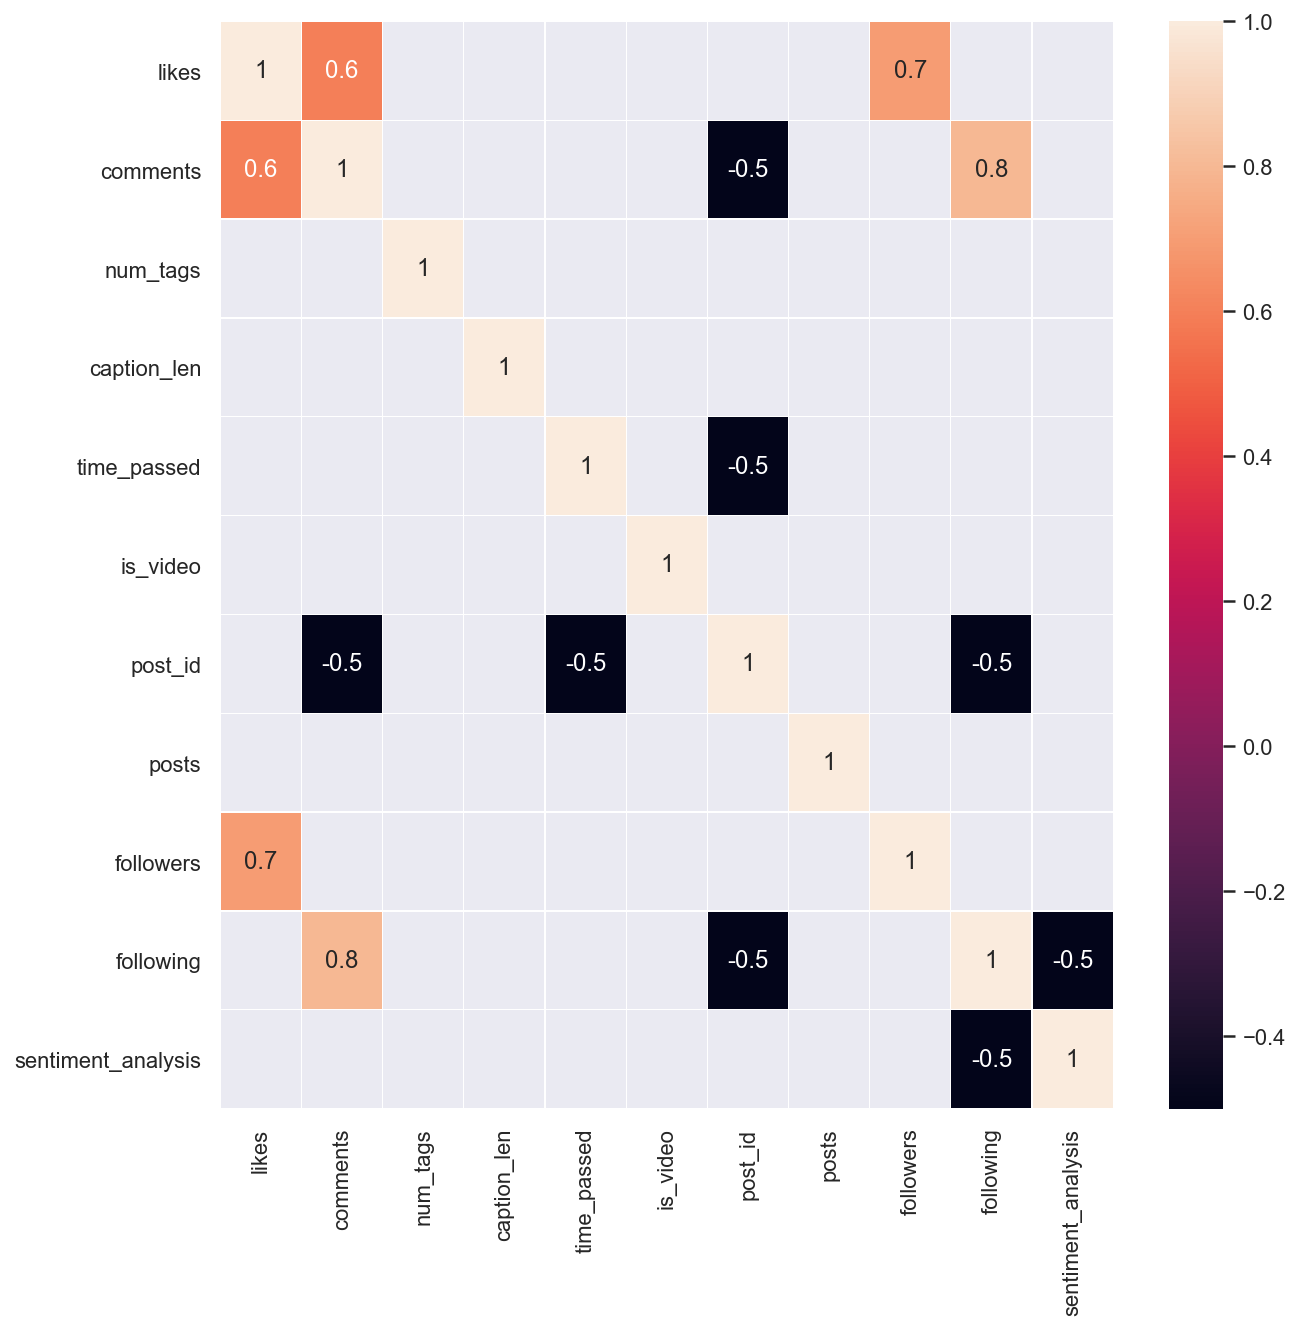

In [29]:
#masking low correlations
plt.figure(figsize = (10,10))
mask = [[ np.abs(cor.iat[i,j])<0.5 for i in range(np.alen(cor))]for j in range(np.alen(cor))] 
sns.heatmap(data=cor, annot=True, mask = mask, linewidths = .1)

We can see a strong correlation between 'followers' and 'comments' with 'likes'

###Data Cleaning

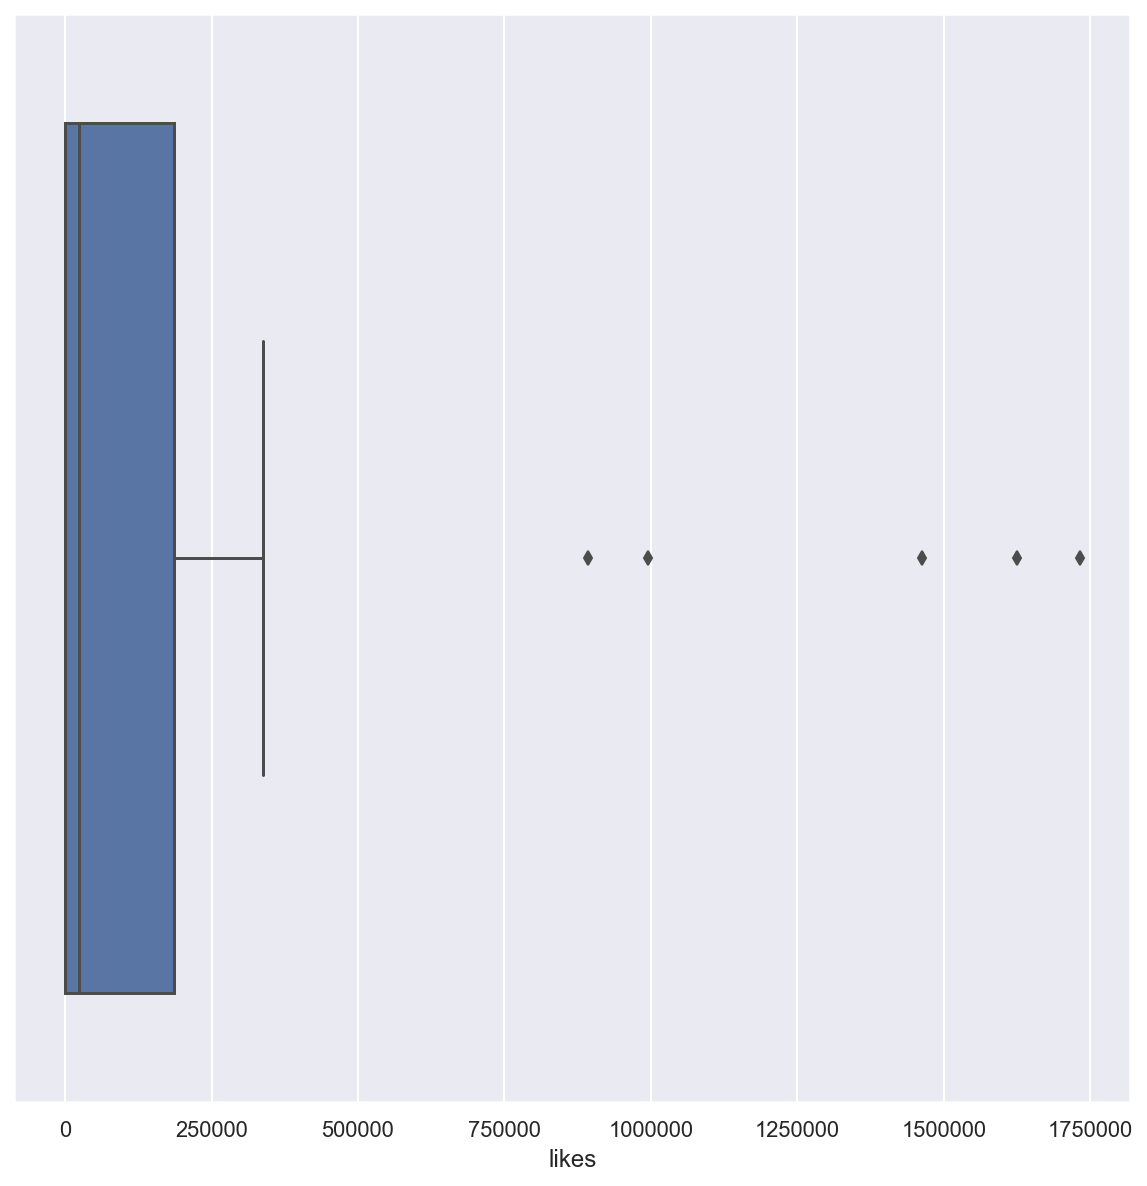

In [30]:
sns.boxplot(x=latest_data_num['likes'])


The boxplot shows that there are some outliers and that the 'likes' data is skewed to the right. To avoid bias in our analysis, we elimanate the extreme outliers by calculating the z-score of the 'likes' data.

In [31]:
z = np.abs(stats.zscore(latest_data_num['likes']))
print(z)

[0.64193364 0.64089826 0.64082213 ... 1.92546692 1.92619016 1.9267916 ]


In [32]:
threshold = 1
print(np.where(z > threshold))

(array([ 342,  343,  344,  345,  346,  347,  348,  349,  350,  351,  352,
        353,  354,  355,  356,  357,  358,  359,  360,  361,  362,  363,
        364,  365,  366,  367,  368,  369,  370,  371,  372,  373,  374,
        375,  376,  377,  378,  379,  380,  381,  382,  383,  384,  385,
        386,  387,  388,  389,  390,  391,  392,  393,  394,  395,  396,
        397,  398,  399,  400,  401,  402,  403,  404,  405,  406,  407,
        408,  409,  410,  414,  415,  416,  417,  418,  419,  420,  421,
        422,  423,  424,  425,  426,  427,  428,  429,  430,  431,  432,
        433,  434,  435,  436,  437,  438,  439,  440,  441,  442,  443,
        444,  445,  446,  447,  448,  449,  450,  451,  452,  453,  454,
        772,  773,  774,  780,  898,  899, 1170, 1171, 1172, 1173, 1174,
       1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185,
       1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196,
       1197, 1198, 1199, 1200, 1201, 1202, 1203, 1

In [33]:
latest_data_num.shape

(1214, 10)

In [34]:
latest_data_num = latest_data_num[latest_data_num['likes']<.5*10**6]

In [35]:
latest_data_num.shape

(1209, 10)

# Modelling the data and making predictions
## -Koppar Devansh Sunil (U1823660K)

After having cleaned the data and exploring it visually, this section of the notebook will use various regression models to predict the number of likes an Instagram post is likely to receive. We will be using the following models and comparing their results:

*   Linear Regression
*   Polynomial Regression
*   SciKit-learn MLPRegressor
*   Custom Neural Network made using TensorFlow











1) Importing the required libraries

In [36]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
# visualization library
%matplotlib inline
import seaborn as sb
# scikit-learn library
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ImportError: cannot import name 'executing_eagerly' from 'tensorflow.python.eager.context' (/Users/naseer2426/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/context.py)

In [ ]:
latest_data.head(n=15)

# Linear Regression

In [ ]:
n =  latest_data_num.shape[0]
print('Number of training data=',n)

Our exploratory data analysis showed us that the length of a caption, number of tags and the number of following had almost no correlation with the number of likes, so we dropped that column for the final training data

In [ ]:
x_train = latest_data[['comments','followers','time_passed']]
y_train = latest_data['likes']
print(x_train)
print()
print(y_train)

Now that the predictors and the target have been created, we can create the model object and fit it to x_train and y_train. Since we have values that vary a lot, we set the Normalize parameter to true.

In [ ]:
linreg = LinearRegression(normalize=True) 
linreg.fit(x_train, y_train)

Now that the model has fit, we can take a look at the learned weights for each predictor.

In [ ]:
print('Coefficients: \n', linreg.coef_)
print('Intercept: \n', linreg.intercept_)

In [ ]:
intercept = linreg.intercept_ 
coef = linreg.coef_
y_train_pred = intercept + np.dot(x_train, coef[:,None])
print(y_train_pred[0].shape)


In [ ]:
loss_sklearn = mean_squared_error(y_train, y_train_pred)

print('Training loss for linear regression=',loss_sklearn)

As we can see, the loss for linear regression is very high, which makes sense since Linear Regression is a very simple model with very low learning capacity and it is unlikely that it would fit well for a complex prediction such as this

# Polynomial Regression

Now we will try using a polynomial function. By increasing the learning capacity, we can probably reduce the loss by some amount. One important choice we need to make is what degree polynomial to use since too high a degree would overfit the data and too low a degree would underfit. We can do this using cross-validation.

1) First we need to split the data into train and validation data

In [ ]:
from sklearn.model_selection import train_test_split
x_train = latest_data[['comments','followers','time_passed']]
y_train = latest_data['likes']

In [ ]:
x_train_poly, x_val_poly, y_train_poly, y_val_poly = train_test_split(x_train, y_train)

2) Now, we need to loop through possible values for the degree of the polynomial and tabulate the loss values for each degree. We cannot use train loss to judge the best degree since train loss will always reduce for a higher degree.

In [ ]:
polyreg = LinearRegression(normalize=True)
degrees = [2,3,4,5,6,7,8,9]

train_errors_tab = np.zeros(len(degrees))
val_errors_tab = np.zeros(len(degrees))
percentage_errors = []

for i,d in enumerate(degrees):
    
    poly = PolynomialFeatures(d)
    
    x_poly = poly.fit_transform(x_train_poly)
    polyreg.fit(x_poly, y_train_poly)
    y_train_pred2 = polyreg.predict(x_poly)
    train_error = mean_squared_error(y_train_poly, y_train_pred2)
    train_errors_tab[i] = train_error

      
    
    x_val = poly.fit_transform(x_val_poly)
    y_val_pred = polyreg.predict(x_val)
    val_error = mean_squared_error(y_val_poly,y_val_pred)
    val_errors_tab[i] = val_error

3) Now we can plot the training error with respect to the degree

In [ ]:
plt.figure(1)
plt.plot(degrees, train_errors_tab,label='Train error'.format(i=1))
plt.legend(loc='best')
plt.title('Error w.r.t. d (Learning capacity)')
plt.xlabel('degree')
plt.ylabel('Error')
plt.show()

As we can see, the training loss goes down to almost zero as we increase the learning capactiy of the model. This makes sense because with a higher learning capacity the model can overfit the training data perfectly. A higher learning capacity means that the model has high variance and can exactly memorise the training data.

Now, we shall try plotting the validation error with respect to learning capacity.

In [ ]:
plt.figure(1)
plt.plot(degrees, val_errors_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. d (Learning capacity)')
plt.xlabel('degree')
plt.ylabel('Error')
plt.show()

Clearly, the graph for the validation data is very different than the training data. The validation data is data that the model has never seen before and hence helps us to judge the model's ability to predict values for unseen data. To find the ideal degree of polynomial suited for our task, we must see which degree has the lowest validation loss, since this model will most likely perform better with unseen data. We cannot use training loss for this as the degree with the lowest training loss would over fit the training data and hence be bad at generalizing

In [ ]:
ideal_degree = degrees[np.argmin(val_errors_tab)]
print("The ideal degree for a polynomial regression is "+str(ideal_degree))

In [ ]:
print("Degree 2 polynomial model error: "+str(min(val_errors_tab)))

Thus, using the losses from the validation set, we can conclude that the model with degree 2 has the best ability to generalise its prediction. The polynomial function however, still has a very high error. Now we will try using a neural network, which has a much better learning capacity

# MLPRegressor Neural Network

Now we will try using a neural network built into the SciKit-Learn library

In [ ]:
sknn = MLPRegressor()

In [ ]:
sknn.fit(x_train,y_train)

In [ ]:
y_nn_pred = sknn.predict(x_train)
print(mean_squared_error(y_train,y_nn_pred))

Clearly, the scikit-learn neural network did not perform much better than our simpler models earlier. In order to improve, we will now try a custom Neural Network in Google's TensorFlow framework.

# TensorFlow Neural Network

Using TensorFlow, we can define our own Neural Network and control parameters such as the layers, neurons, activation functions, etc. We will use a layer with 5 dense layers. The first 4 will have 256 neurons each and relu activation functions. The last layer will have one neuron since it outputs ony a single value, i.e. the number of likes.

In [ ]:
tf_nn_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256,activation='relu',input_dim = x_train.shape[1]),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(1,activation='linear'),
       
])
tf_nn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

The following function provides a summary of all the layers and their inputs and outputs

In [ ]:
tf_nn_model.summary()

In [ ]:
tf_nn_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split = 0.2)

As we can see from above, after 500 epochs of training, the neural network reached an MSE validation error of about 50,000. This is significantly better than the previous models we used

To conclude, the following observations can be made:


*   The predictors used may not have been the best, we might have missed some better predictors that would improve performance.
*   Neural Networks are heavily influenced by hyperparameters like number of layers, number of neurons, activation functions etc etc. The TensorFlow NN performed significantly better than the scikitlearn one.



